In [1]:
import os    
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda,floatX=float32"

import numpy as np
from sklearn.utils import shuffle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import math

from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, UpSampling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Deconvolution2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.layers.core import Flatten
from keras.constraints import maxnorm

import keras.regularizers

from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator


img_rows = 32
img_cols = 32


Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


/home/mrafi123/anaconda3/lib/python3.5/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce 920M (0000:08:00.0)


In [2]:
#test for gpu
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<GpuArrayType<None>(float32, (False,))>), HostFromGpu(gpuarray)(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.842412 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [3]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


No of Surrogate classes 50 - 32000 ----8000 is optimum
No of Samples Per Surrogate class - 1 to 300
According to the paper

but for our purpose
can we random select say 100 images - check thier distribution
loop each of this image and automatically image augmentation for 200 images
Label this 200 images as one surrogate classes
100*200 = 20000 images and 100 labels



In [4]:
split = 50
divided_input = np.split(x_train, split)
X_train = divided_input[0]

divided_output = np.split(y_train, split)
Y_train = divided_output[0]

unique, counts = numpy.unique(Y_train, return_counts=True)
print (dict(zip(unique, counts)))

{0: 102, 1: 112, 2: 99, 3: 92, 4: 99, 5: 85, 6: 107, 7: 102, 8: 99, 9: 103}


In [5]:
print(X_train.shape)
print(Y_train.shape)
print (len(X_train))

(1000, 3, 32, 32)
(1000, 1)
1000


# We need a new set of training labels Y_Surr_Train
# for 100 images it has to labelled from 0 -99
# instead of the original label (0-9) from the actual cifar data set


In [6]:
Y_train_Surr = np.arange(len(X_train))

In [7]:
Y_train_Surr = Y_train_Surr.reshape(len(X_train),1)
Y_train_Surr.shape

(1000, 1)

In [8]:
X_train = X_train.astype('float32')
X_train /= 255
print(X_train.shape)

(1000, 3, 32, 32)


In [9]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        shear_range=0.3, #Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
        zoom_range=0.3 , #Float or [lower, upper]. Range for random zoom. If a float,  [lower, upper] = [1-zoom_range, 1+zoom_range].
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images




Using real-time data augmentation.


In [10]:
i=0
generated_images = np.empty(shape=[0,3,32,32])
generated_labels = np.empty(shape=[0,1])


for i in range(50):
    
    for X_batch,Y_batch in datagen.flow(X_train,Y_train_Surr,batch_size=len(X_train)):
        generated_images = np.concatenate((generated_images, X_batch))
        generated_labels = np.concatenate((generated_labels, Y_batch))
        break  # otherwise the generator would loop indefinitely

    i+=1
    if i >= 50:
        break


In [11]:
print (X_train.shape)
print (Y_train_Surr.shape)

print (X_batch.shape)
print (Y_batch.shape)
print (generated_images.shape)
print (generated_labels.shape)


(1000, 3, 32, 32)
(1000, 1)
(1000, 3, 32, 32)
(1000, 1)
(50000, 3, 32, 32)
(50000, 1)


In [12]:
image = X_train.reshape(X_train.shape[0], 3, 32, 32).transpose(0,2,3,1)
print (image.shape)
#print (image[0])
image = image*127.5+127.5
#print (image[0])
Image.fromarray(image[0].astype(np.uint8)).save("actual_image.png")


(1000, 32, 32, 3)


In [13]:
unique, counts = numpy.unique(generated_labels, return_counts=True)
print (dict(zip(unique, counts)))

{0.0: 50, 1.0: 50, 2.0: 50, 3.0: 50, 4.0: 50, 5.0: 50, 6.0: 50, 7.0: 50, 8.0: 50, 9.0: 50, 10.0: 50, 11.0: 50, 12.0: 50, 13.0: 50, 14.0: 50, 15.0: 50, 16.0: 50, 17.0: 50, 18.0: 50, 19.0: 50, 20.0: 50, 21.0: 50, 22.0: 50, 23.0: 50, 24.0: 50, 25.0: 50, 26.0: 50, 27.0: 50, 28.0: 50, 29.0: 50, 30.0: 50, 31.0: 50, 32.0: 50, 33.0: 50, 34.0: 50, 35.0: 50, 36.0: 50, 37.0: 50, 38.0: 50, 39.0: 50, 40.0: 50, 41.0: 50, 42.0: 50, 43.0: 50, 44.0: 50, 45.0: 50, 46.0: 50, 47.0: 50, 48.0: 50, 49.0: 50, 50.0: 50, 51.0: 50, 52.0: 50, 53.0: 50, 54.0: 50, 55.0: 50, 56.0: 50, 57.0: 50, 58.0: 50, 59.0: 50, 60.0: 50, 61.0: 50, 62.0: 50, 63.0: 50, 64.0: 50, 65.0: 50, 66.0: 50, 67.0: 50, 68.0: 50, 69.0: 50, 70.0: 50, 71.0: 50, 72.0: 50, 73.0: 50, 74.0: 50, 75.0: 50, 76.0: 50, 77.0: 50, 78.0: 50, 79.0: 50, 80.0: 50, 81.0: 50, 82.0: 50, 83.0: 50, 84.0: 50, 85.0: 50, 86.0: 50, 87.0: 50, 88.0: 50, 89.0: 50, 90.0: 50, 91.0: 50, 92.0: 50, 93.0: 50, 94.0: 50, 95.0: 50, 96.0: 50, 97.0: 50, 98.0: 50, 99.0: 50, 100.0: 50

In [14]:
num_classes = len(X_train)
generated_labels = np_utils.to_categorical(generated_labels, num_classes)

In [15]:
print (generated_images.shape)
print (generated_labels.shape)

(50000, 3, 32, 32)
(50000, 1000)


In [16]:
from sklearn.model_selection import train_test_split
generated_images_train, generated_images_val, generated_labels_train, generated_labels_val = train_test_split(
    generated_images,generated_labels,test_size=0.1, random_state=42)

In [17]:
print (generated_images_train.shape)
print (generated_labels_train.shape)
print (generated_images_val.shape)
print (generated_labels_val.shape)

(45000, 3, 32, 32)
(45000, 1000)
(5000, 3, 32, 32)
(5000, 1000)


In [17]:
# Architecture is changed from ver-2 and 
# no of surrogate classes increased
def cnn_model():
    model = Sequential()
    model.add(Convolution2D(64, 5, 5, border_mode='same',subsample=(2, 2),input_shape=(3, 32, 32)))
    model.add(LeakyReLU(0.2))
    model.add(Convolution2D(128, 5, 5, border_mode='same',subsample=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Convolution2D(256, 5, 5, border_mode='same',subsample=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Convolution2D(512, 5, 5, border_mode='same',subsample=(4, 4)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model


model2 = cnn_model()
modeladam = cnn_model()
modelada = cnn_model()

lr = 0.01

sgd = SGD(lr=lr, decay=1e-5, momentum=0.8, nesterov=True)

model2.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

modeladam.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

modelada.compile(loss='categorical_crossentropy',
          optimizer='adadelta',
          metrics=['accuracy'])

In [18]:
modeladam.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 64, 16, 16)    4864        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
leakyrelu_5 (LeakyReLU)          (None, 64, 16, 16)    0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 128, 8, 8)     204928      leakyrelu_5[0][0]                
____________________________________________________________________________________________________
leakyrelu_6 (LeakyReLU)          (None, 128, 8, 8)     0           convolution2d_6[0][0]            
___________________________________________________________________________________________

In [19]:
nb_epochs=2
batch_size = 128
kfold_weights_path = os.path.join('weights_' +  'CIFAR10-Exemplar-Ver5.0' +
                                  '_epoch_'+str(nb_epochs)+
                                  '_batch_'+str(batch_size)
                                  +'.h5')
print(kfold_weights_path)

weights_CIFAR10-Exemplar-Ver5.0_epoch_2_batch_128.h5


In [20]:
os.path.isfile(kfold_weights_path)

False

In [21]:
# Some transfer learning
if os.path.isfile(kfold_weights_path):
    print ('Loading already stored weights...')
    modeladam.load_weights(kfold_weights_path)
else:
    print ('Training for the first time...')
    

Training for the first time...


In [22]:
print (generated_images_train.shape)
print (generated_labels_train.shape)
print (generated_images_val.shape)
print (generated_labels_val.shape)

(45000, 3, 32, 32)
(45000, 2000)
(5000, 3, 32, 32)
(5000, 2000)


#### Let us visualize randomly

In [28]:
    image = generated_images_train.reshape(generated_images_train.shape[0], 3, 32, 32).transpose(0,2,3,1)
print (image.shape)
#print (image[0])
image = image*127.5+127.5
#print (image[0])
Image.fromarray(image[1].astype(np.uint8)).save("generated_image.png")


(90000, 32, 32, 3)


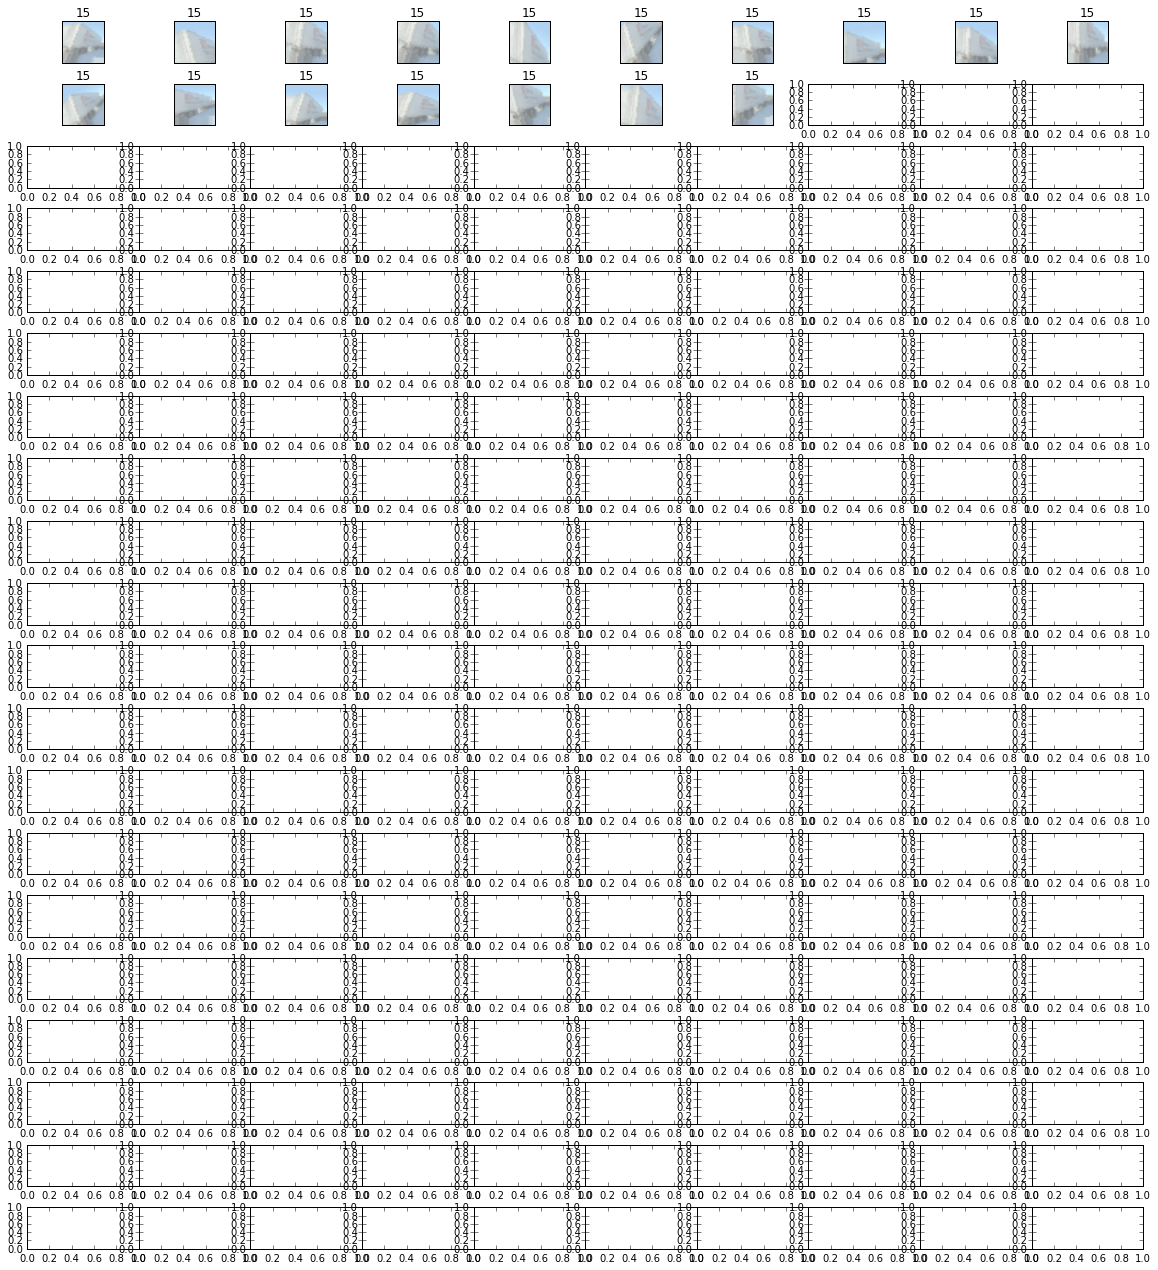

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

n = 36000  # how many digits we will display
rows=20
columns=10
fig, axs = plt.subplots(rows,columns,figsize=(20, 22))

plt.gray()
fig.subplots_adjust(hspace = .5, wspace=.001)

#for r in range(rows):
r=0
c=0

image = generated_images_train.reshape(generated_images_train.shape[0], 3, 32, 32).transpose(0,2,3,1)
image = image*127.5+127.5


for i in range(n):
    if np.argmax(generated_labels_train[i]) == 15:
        axs[r, c].imshow(Image.fromarray(image[i].astype(np.uint8)))
        axs[r, c].set_title(np.argmax(generated_labels_train[i]))
        axs[r, c].get_xaxis().set_visible(False)
        axs[r, c].get_yaxis().set_visible(False)
        #print (r,c)
        c=c+1
        if c==10:
            #print ('breaking to next row')
            r=r+1
            c=0

plt.show()


In [25]:
nb_epochs=50


In [26]:
callbacks = [
                EarlyStopping(monitor='val_loss', patience=2, verbose=1),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', 
                                save_best_only=True, 
                                verbose=1),
            ]
modeladam.fit(generated_images_train, generated_labels_train,
            nb_epoch=nb_epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(generated_images_val, generated_labels_val),
            callbacks=callbacks
            )

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 336s - loss: 0.9874 - acc: 0.7198 - val_loss: 0.6540 - val_acc: 0.8230
Epoch 2/50
45000/45000 [==============================] - 337s - loss: 0.5677 - acc: 0.8307 - val_loss: 0.5467 - val_acc: 0.8520
Epoch 3/50
45000/45000 [==============================] - 335s - loss: 0.3805 - acc: 0.8847 - val_loss: 0.4796 - val_acc: 0.8648
Epoch 4/50
45000/45000 [==============================] - 336s - loss: 0.2967 - acc: 0.9077 - val_loss: 0.3590 - val_acc: 0.9086
Epoch 5/50
45000/45000 [==============================] - 335s - loss: 0.2849 - acc: 0.9127 - val_loss: 0.4109 - val_acc: 0.8960
Epoch 6/50
45000/45000 [==============================] - 338s - loss: 0.2467 - acc: 0.9251 - val_loss: 0.3335 - val_acc: 0.9134
Epoch 7/50
45000/45000 [==============================] - 336s - loss: 0.1973 - acc: 0.9410 - val_loss: 0.4320 - val_acc: 0.8962
Epoch 8/50
45000/45000 [========================

In [33]:
# Now that we have generated a weights file
# we need a method to do some transfer learning
# train the last few layers to predict the original 10 classes


In [27]:
feature_layers = [
    Convolution2D(64, 5, 5, border_mode='same', subsample=(2, 2),input_shape=(3, 32, 32), activation='relu'),
    Dropout(0.5),
    Convolution2D(128, 5, 5, border_mode='same', subsample=(2,2) , activation='relu'),
    Dropout(0.5),
    Convolution2D(256, 5, 5, border_mode='same', subsample=(2,2) , activation='relu'),
    Dropout(0.5),
    Convolution2D(512, 5, 5, border_mode='same', subsample=(4,4) , activation='relu'),
    Dropout(0.5),
    Flatten()
]

classification_layers = [
    Dense(512, W_regularizer=keras.regularizers.l2(0.01), name='fc_layer1'),
    Activation('sigmoid'),
    Dense(10, activation='softmax', W_regularizer=keras.regularizers.l2(0.01), name='fc_layer2')
]



In [28]:
#print model.summary()

model = Sequential(feature_layers + classification_layers)


In [29]:
model.load_weights(kfold_weights_path, by_name=True)

for l in feature_layers:
    print (l)
    l.trainable = False

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print('Model Compilation successful')

Model Compilation successful


In [48]:
lr = 0.1

sgd = SGD(lr=lr, decay=1e-5, momentum=0.8, nesterov=True)

model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [31]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_13 (Convolution2D) (None, 64, 16, 16)    4864        convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 64, 16, 16)    0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 128, 8, 8)     204928      dropout_4[0][0]                  
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 128, 8, 8)     0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [32]:
# No point in traiing all 50K images
# beats the purpose of semi-supervised learning
# reduce the 50 K to 5 K samples with original labels
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

split = 10
divided_input = np.split(x_train, split)
x_train_semisup = divided_input[0]

divided_output = np.split(y_train, split)
y_train_semisup = divided_output[0]
print (x_train_semisup.shape)
print (y_train_semisup.shape)
unique, counts = numpy.unique(y_train_semisup, return_counts=True)
print (dict(zip(unique, counts)))

(5000, 3, 32, 32)
(5000, 1)
{0: 505, 1: 460, 2: 519, 3: 486, 4: 519, 5: 488, 6: 519, 7: 486, 8: 520, 9: 498}


In [33]:
x_train_semisup = x_train_semisup.astype('float32')
x_train_semisup /= 255
print(x_train_semisup.shape)

(5000, 3, 32, 32)


In [34]:
num_real_classes =10
# Convert class vectors to binary class matrices.
y_train_semisup = np_utils.to_categorical(y_train_semisup, num_real_classes)
y_test = np_utils.to_categorical(y_test, num_real_classes)
print(y_train_semisup.shape)
print(y_test.shape)

(5000, 10)
(10000, 10)


In [35]:
model.fit(x_train_semisup, y_train_semisup, batch_size=batch_size, nb_epoch=50,
          verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 5000 samples, validate on 10000 samples
Epoch 1/50
5000/5000 [==============================] - 6s - loss: 5.0253 - acc: 0.1056 - val_loss: 3.3542 - val_acc: 0.0999
Epoch 2/50
5000/5000 [==============================] - 6s - loss: 2.7889 - acc: 0.1068 - val_loss: 2.7096 - val_acc: 0.1083
Epoch 3/50
5000/5000 [==============================] - 7s - loss: 2.5002 - acc: 0.1002 - val_loss: 2.6037 - val_acc: 0.1431
Epoch 4/50
5000/5000 [==============================] - 7s - loss: 2.4664 - acc: 0.1006 - val_loss: 2.5554 - val_acc: 0.1151
Epoch 5/50
5000/5000 [==============================] - 7s - loss: 2.4609 - acc: 0.1020 - val_loss: 2.4643 - val_acc: 0.1150
Epoch 6/50
5000/5000 [==============================] - 7s - loss: 2.4509 - acc: 0.0986 - val_loss: 2.4577 - val_acc: 0.1122
Epoch 7/50
5000/5000 [==============================] - 7s - loss: 2.4299 - acc: 0.0994 - val_loss: 2.6103 - val_acc: 0.0999
Epoch 8/50
5000/5000 [==============================] - 7s - loss: 2.4217 - 